# Распознавание образов с использованием SVM

## Задача

Воспользовавшись классификатором SVM, определите вероятности ошибок классификации линейно __неразделимых__ выборок двух классов для следующих типов ядер: 
- RBF
- полиномиальная функция

Определите оптимальную функцию ядра.

## Решение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split,GridSearchCV, learning_curve,ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from prettytable import PrettyTable

from utils import make_meshgrid, plot_contours, plot_learning_curve

### Выборка

Cгенерируем линейно неразделимую выборку:

In [2]:
X,y = make_circles(n_samples=1000,noise=0.2,factor=0.25,random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 17)

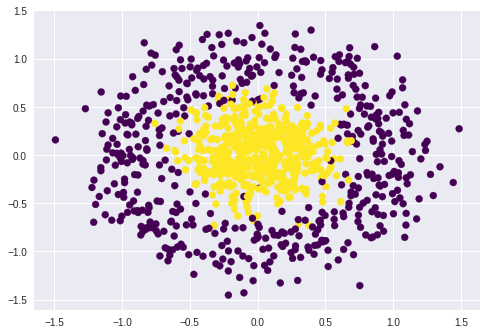

In [3]:
plt.scatter(X[:,0],X[:,1],c = y,cmap = 'viridis');

### Модель

#### Ядро

1. Полиномиальное ядро  
$$K(x,z) = (x^{T}z + c)^{p}$$

2. Радиальное ядро(RBF)
$$K(x,z) = exp(-\gamma\Vert{x-z}\Vert^{2})$$


In [4]:
kernels = ['linear','poly', 'rbf']
models  = []

Выполним обучение моделей с гиперпараметрами по умолчанию:
- __C__ = 1.0 - позволяет найти баланс между максимизацией разделяющей полосы и минимизацией суммарной ошибки;
когда С - маленький, классификатор допускает наличие ошибок при классификации(high bias, low variance);
когда С - большой, классификатор "наказывается" за допущенные ошибки(low bias, high variance).
- __degree__ = 3 - степень полинома(для полиномиального ядра)
- __gamma__ = 'auto'(1/n_features)

Посмотреть, как изменяются области принятия решений в зависимости от параметров можно <a href = "https://chrisalbon.com/machine-learning/svc_parameters_using_rbf_kernel.html">здесь</a>

In [5]:
t = PrettyTable(['Kernel','Train','Test'])
for kernel in kernels:
    clf = SVC(kernel=kernel)
    model = clf.fit(X_train,y_train)
    models.append(model)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    t.add_row([kernel, accuracy_score(y_train,train_pred),accuracy_score(y_test,test_pred)])
print(t)

+--------+----------------+----------------+
| Kernel |     Train      |      Test      |
+--------+----------------+----------------+
| linear | 0.638571428571 |      0.63      |
|  poly  | 0.565714285714 |      0.54      |
|  rbf   | 0.958571428571 | 0.966666666667 |
+--------+----------------+----------------+


In [6]:
titles = ['Linear kernel',
          'Polynomial kernel',
          'RBF kernel']
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

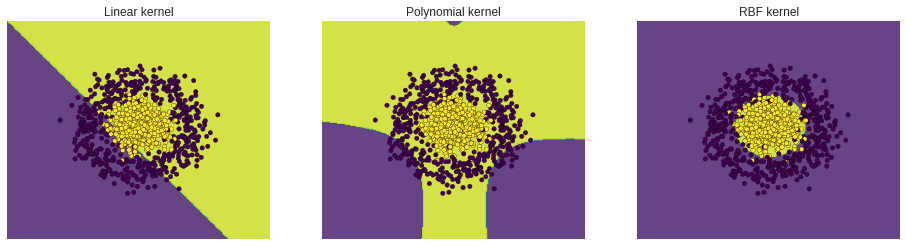

In [7]:
fig, sub = plt.subplots(1, 3,figsize = (16,4))
for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap='viridis', alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap='viridis', s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

Как можно видеть, без настройки с задачей классификации хорошо справляется только SVM с радиальным ядром.

### Поиск оптимального ядра

Для радиального ядра будем настраивать $\gamma$, а для полиномиального - степень $p$.

In [8]:
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1]
degree = np.arange(1,21,1)

In [9]:
tuned_parameters = [{'kernel': ['poly'],'C': C, 'degree': degree},
                    {'kernel': ['rbf'], 'gamma': gamma,'C': C}]

In [10]:
%%time
best_models = []
score = 'accuracy'
for t in tuned_parameters:
    clf = GridSearchCV(SVC(random_state=17), t, cv=5,scoring='precision',n_jobs=-1)
    clf.fit(X_train, y_train)
    best_models.append(clf.best_estimator_)
    print("Лучшие параметры на обучающей выборке:")
    print()
    print(clf.best_params_)
    print()
    print("Отчет:")
    print()
    print("Модель обучена на всей обучающей выборке.")
    print("Оценки рассчитаны на тестовой выборке.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print('Процент ошибок на тестовой выборке: {0:.2f}%'.format((1-accuracy_score(y_true,y_pred))*100))
    print()

Лучшие параметры на обучающей выборке:

{'C': 100, 'degree': 2, 'kernel': 'poly'}

Отчет:

Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       152
          1       0.99      0.94      0.96       148

avg / total       0.96      0.96      0.96       300

Процент ошибок на тестовой выборке: 3.67%

Лучшие параметры на обучающей выборке:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Отчет:

Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.

             precision    recall  f1-score   support

          0       0.94      0.99      0.97       152
          1       0.99      0.94      0.97       148

avg / total       0.97      0.97      0.97       300

Процент ошибок на тестовой выборке: 3.33%

CPU times: user 816 ms, sys: 36 ms, total: 852 ms
Wall time: 7.16 s


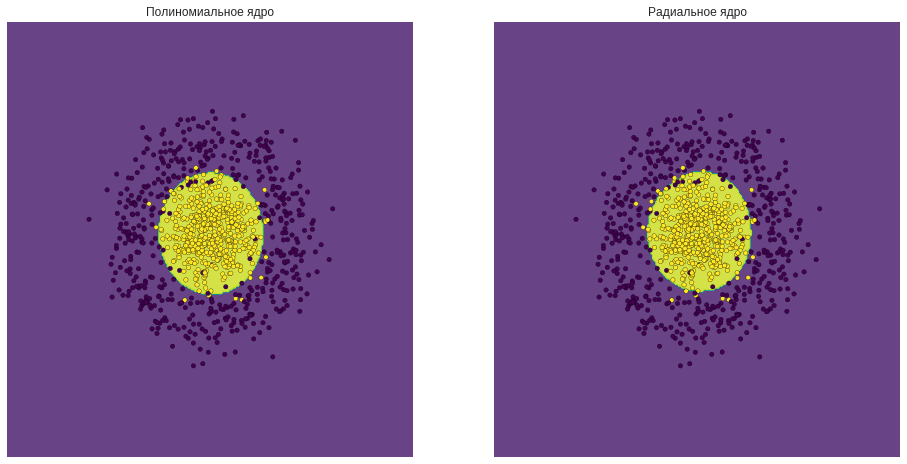

In [11]:
titles = ['Полиномиальное ядро',
          'Радиальное ядро']
fig, sub = plt.subplots(1, 2,figsize = (16,8))
for clf, title, ax in zip(best_models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap='viridis', alpha=0.8,)
    ax.scatter(X0, X1, c=y, cmap='viridis', s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

Построим кривые обучения:

In [12]:
estimator1 = best_models[0]
estimator2 = best_models[1]
title1 = "Кривые обучения(SVC,poly,p = 4)"
title2 = "Кривые обучения(SVC,RBF,gamma = 1)"

In [13]:
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=17)

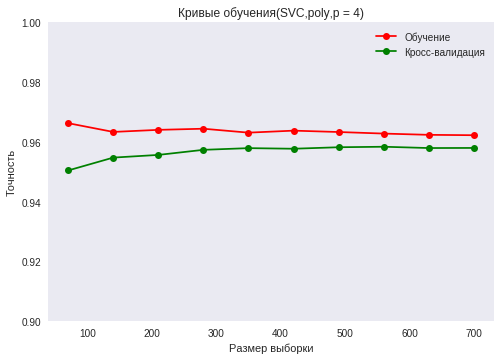

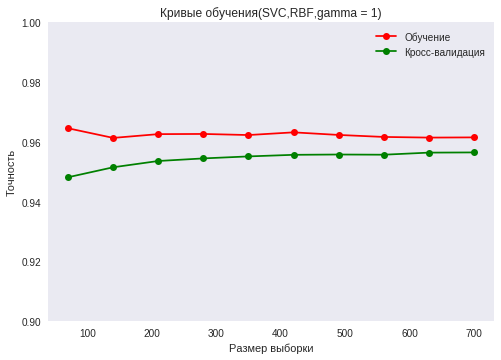

In [14]:
plot_learning_curve(estimator1, title1, X, y, ylim=(0.9, 1.0), cv=cv, n_jobs=-1);
plot_learning_curve(estimator2, title2, X, y, ylim=(0.9, 1.0), cv=cv, n_jobs=-1);